In [1]:
import gensim.downloader as api
model_glove = api.load("glove-wiki-gigaword-300")

In [46]:
import pandas as pd
from nltk import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
from keras.preprocessing import sequence
from keras.layers import Input, Dense, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
import tensorflow as tf
from keras.callbacks import EarlyStopping
import numpy as np
df = pd.read_csv('cleaned_stock_trend.csv')


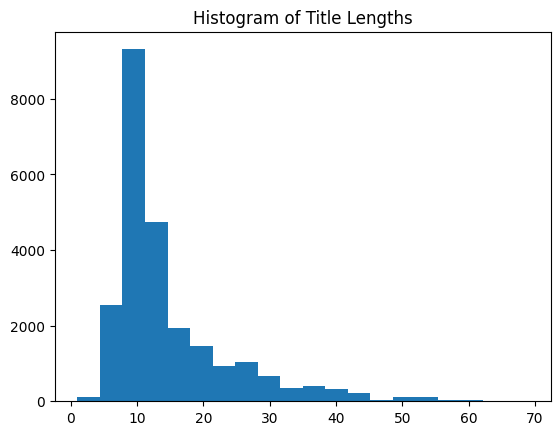

In [47]:
# Get the distribution of title lengths
df['Title_Tokenized'] = df['Title'].apply(word_tokenize)
df['Title_Len'] = df['Title_Tokenized'].apply(len)
import matplotlib.pyplot as plt
plt.hist(df['Title_Len'], bins=20)
plt.title('Histogram of Title Lengths')
plt.show()  

In [48]:
# Average length
avg_len = int(df['Title_Len'].mean())
print(f'Average Title Length: {avg_len}')

Average Title Length: 14


In [49]:
sent_length = 30
n_features = 300
n_outputs = 3
batch_size = 32
epochs = 10

# Remove special characters from titles
import re
def clean_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text
df['Title'] = df['Title'].apply(clean_text)
# Convert documents to embeddings
docs_embedding = list()
for doc in df['Title']:
    tokens = word_tokenize(doc.lower())
    # To handle OOV words, we use try-except block
    for i in range(len(tokens)):
        try:
            model_glove[tokens[i]]
        except KeyError:
            tokens[i] = 'unk'  # Replace OOV word with 'unk'
    embedding = model_glove[tokens]
    docs_embedding.append(embedding)
    print(f"Processed document: {doc}")
    
# Pad embedding sequence so that each document has the same length
from keras.preprocessing.sequence import pad_sequences
X = sequence.pad_sequences(docs_embedding, maxlen=sent_length, dtype='int32')
X = np.array(X)
print(X.shape)

Processed document:  startups participate in Maxis Market Access Day
Processed document:  stake in Subur Tiasa traded offmarket
Processed document: Najib wanted MDBs Genting Sanyen deal sped up on fears caretaker govt couldnt approve it  witness
Processed document: bps OPR cut likely in H says Manulife
Processed document: A month extension on concession pushes Pharmaniaga up by 
Processed document:  of Yong Tai transacted offmarket
Processed document: A Ruberex Thriven Kanger UniWall
Processed document:  stake in IWHCREC may cost Ekovest RMb
Processed document:  Kronologi Asia shares traded offmarket
Processed document:  of MMAG traded off market
Processed document: A  stake in Media Prima crosses off market at same price paid by Syed Mokhtar
Processed document:  of Sern Kou Resources traded in two offmarket deals
Processed document:  stake in Jiankun International traded off market
Processed document:  stake in GHL Systems traded offmarket
Processed document:  stake in Green Packet cr

Train set: (17071, 30, 300), Validation set: (4878, 30, 300), Test set: (2439, 30, 300)
y_train label count:
0    15844
2      871
1      356
Name: count, dtype: int64

y_val label count:
0    4519
2     237
1     122
Name: count, dtype: int64

y_test label count:
0    2263
2     124
1      52
Name: count, dtype: int64


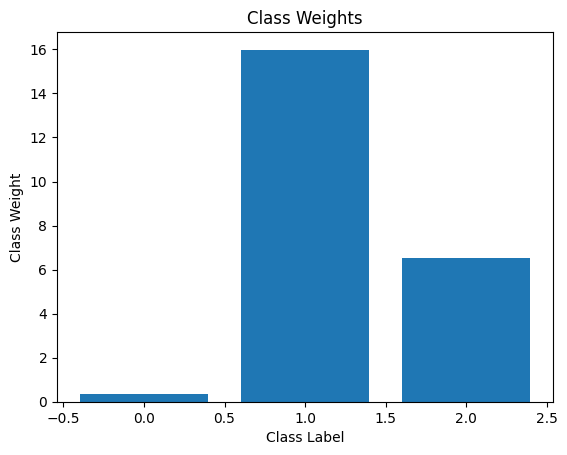

In [50]:
# Train Test Split
from sklearn.model_selection import train_test_split
y = to_categorical(df['Trend_Label'], num_classes=n_outputs)
# Train 70%, Validation 20%, Test 10%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)
print(f'Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')
# Print each set label count for each set
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("y_train label count:")
print(pd.Series(y_train_labels).value_counts())
print("\ny_val label count:")
print(pd.Series(y_val_labels).value_counts())
print("\ny_test label count:")
print(pd.Series(y_test_labels).value_counts())

# Compute class weights to handle class imbalance
y_train_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))
# plot class weights
import matplotlib.pyplot as plt
plt.bar(class_weight_dict.keys(), class_weight_dict.values())
plt.xlabel('Class Label')
plt.ylabel('Class Weight')
plt.title('Class Weights')
plt.show()


## **Step 3: LSTM Model Training & Prediction**

In Step 3, the LSTM model is constructed, trained, and used for prediction. The predicted labels are then compared to the true labels to evaluate model performance.

In [51]:
# --- SETUP: Define the grid to search ---
lstm_options = [128]      
dropout_options = [0.3] 
batch_size_options = [32]
fixed_lr = 0.0001
best_score = 0
best_params = {}
print(f"Starting Grid Search with LR={fixed_lr}...\n")
# for units in lstm_options:
#     for dropout in dropout_options:
#         for batch_size in batch_size_options:
#             print(f"Training model with units={units}, dropout={dropout}, batch_size={batch_size}...")
#             # Build the model
#             inputs = Input(shape=(sent_length, n_features))
#             x = LSTM(units, dropout=dropout, recurrent_dropout=dropout)(inputs)
#             outputs = Dense(n_outputs, activation='softmax')(x)
#             model = Model(inputs=inputs, outputs=outputs)
#             model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fixed_lr),
#                           loss='categorical_crossentropy',
#                           metrics=['accuracy'])
#             # Early stopping
#             early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#             # Train the model
#             model.fit(X_train, y_train,
#                       validation_data=(X_val, y_val),
#                       epochs=epochs,
#                       batch_size=batch_size,
#                       class_weight=class_weight_dict,
#                       callbacks=[early_stopping],
#                       verbose=0)
#             # Evaluate the model
#             val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
#             print(f"Validation Accuracy: {val_accuracy:.4f}\n")
#             # Update best score and parameters
#             if val_accuracy > best_score:
#                 best_score = val_accuracy
#                 best_params = {'units': units, 'dropout': dropout, 'batch_size': batch_size}
best_params = {'units': 128, 'dropout': 0.3, 'batch_size': 32}
print(f"Best Validation Accuracy: {best_score:.4f} with parameters: {best_params}")
# Evaluate the best model on the test set
# Rebuild the best model
inputs = Input(shape=(sent_length, n_features))
x = LSTM(best_params['units'], dropout=best_params['dropout'], recurrent_dropout=best_params['dropout'])(inputs)
outputs = Dense(n_outputs, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fixed_lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the best model
model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=epochs,
          batch_size=best_params['batch_size'],
          class_weight=class_weight_dict,
          verbose=1)
# Evaluate the keras model
prob = model.predict(X_test)
test = np.argmax(prob, axis = 1)

print(f"\nPrediction Probability:\n{prob}")
print(f"\nPredicted Class Label: {test}")
accuracy = accuracy_score(np.argmax(y_test, axis=1), test)
print(f"\nTest Accuracy: {accuracy}")

Starting Grid Search with LR=0.0001...

Best Validation Accuracy: 0.0000 with parameters: {'units': 128, 'dropout': 0.3, 'batch_size': 32}
Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5235 - loss: 1.0897 - val_accuracy: 0.4932 - val_loss: 1.0642
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.4675 - loss: 1.0702 - val_accuracy: 0.4453 - val_loss: 1.0549
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5336 - loss: 1.0550 - val_accuracy: 0.5174 - val_loss: 1.0414
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5905 - loss: 1.0323 - val_accuracy: 0.4715 - val_loss: 1.0532
Epoch 5/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5683 - loss: 1.0183 - val_accuracy: 0.5365 - val_loss: 0.9809
Epoch 6/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5311 - loss: 1.0012 - val_accuracy: 0.6499 - val_loss: 0.9297
Epoch 7/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5519 - loss: 

In [52]:
# # Define the LSTM layer for computation
# inputs = Input(shape = (sent_length, n_features))
# lstm = LSTM(64, return_sequences = True, return_state = True)
# outputs_seq, state_h, state_c = lstm(inputs)
# flat = Flatten()(outputs_seq)
# outputs = Dense(n_outputs, activation = 'softmax')(flat)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# # Wrap the LSTM layer into a Keras model, connecting the input and output layers to form a single end-to-end model
# model = Model(inputs = inputs, outputs = outputs)
# model.compile(
#     optimizer=optimizer, 
#     loss='categorical_crossentropy', 
#     metrics=['accuracy']
# )
# model.summary()


# # Stop training when the validation loss is not decreasing for 3 consecutive epochs
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Train the keras model
# model.fit(X_train, y_train, validation_data = (X_val, y_val), 
#           epochs = epochs, verbose = 1, batch_size = batch_size, callbacks=[early_stopping], class_weight=class_weight_dict)

# # Evaluate the keras model
# prob = model.predict(X_test)
# test = np.argmax(prob, axis = 1)

# print(f"\nPrediction Probability:\n{prob}")
# print(f"\nPredicted Class Label: {test}")
# accuracy = accuracy_score(np.argmax(y_test, axis=1), test)
# print(f"\nTest Accuracy: {accuracy}")

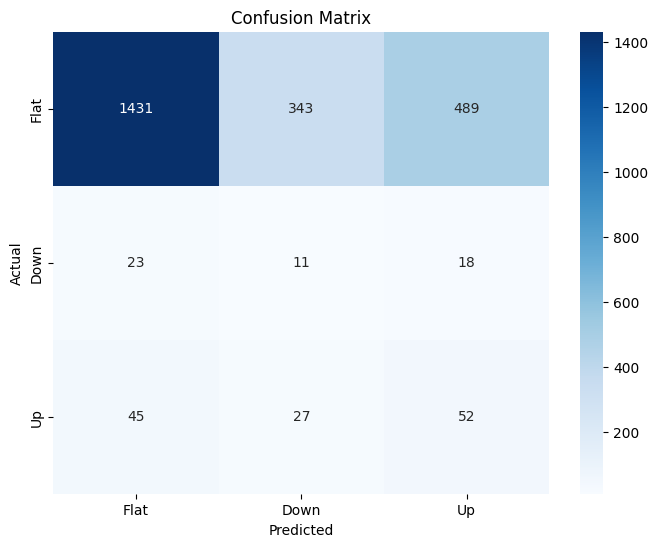


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.63      0.76      2263
           1       0.03      0.21      0.05        52
           2       0.09      0.42      0.15       124

    accuracy                           0.61      2439
   macro avg       0.36      0.42      0.32      2439
weighted avg       0.89      0.61      0.71      2439



In [53]:
# Print Confusion Matrix as heatmap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Flat', 'Down', 'Up'], yticklabels=['Flat', 'Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Print Score
from sklearn.metrics import classification_report
report = classification_report(np.argmax(y_test, axis=1), test)
print(f"\nClassification Report:\n{report}")


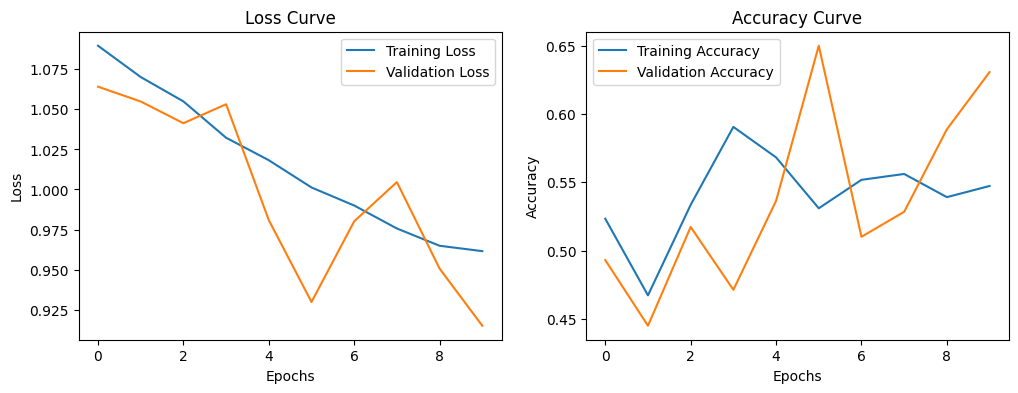

In [54]:
# plot loss and accuracy curves
history = model.history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()